### Import dependencies

In [47]:
import os 
import sys 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt 

sns.set(font='arial')
jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

### Read in source files

In [2]:
source_url = os.getcwd()

rnaseq_url = os.path.join (source_url, "sce_mct1_deduped_counts_count_table.tsv")
rnaseq_metadata_url = os.path.join (source_url, "sce_mct1_metadata.txt")
rna_lengths_url = os.path.join (source_url, "sce_lengths.txt")

proteomics_url = os.path.join (source_url, "proteomics_values.txt")

aa_genelist_url = os.path.join (source_url, "aa_gene_list.csv")
nt_genelist_url = os.path.join (source_url, "GO_0009117_SCE_nucleotide_metabolism.txt")

In [3]:
rnaseq = pd.read_csv(
    rnaseq_url,
    sep="\t",
    index_col=0)
rna_metadata = pd.read_csv(
    rnaseq_metadata_url,
    sep="\t")
rna_lengths = pd.read_csv(
    rna_lengths_url,
    sep="\t",
    index_col=0)
rna_lengths.index.name = None
aa_genes = pd.read_csv(
    aa_genelist_url,
    sep=",")
nt_genes = pd.read_csv(
    nt_genelist_url,
    sep="\t",
    header=None)

proteomics = pd.read_csv(
    proteomics_url,
    sep="\t",
    index_col=0)

### Prepare reference items

In [4]:
rna_length_dict = rna_lengths.to_dict()['Length']

### TPM normalization
1) Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).   
2) Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.   
3) Divide the RPK values by the “per million” scaling factor. This gives you TPM.   
Source: https://rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/

In [5]:
rnaseq_tpm = rnaseq.copy()
print("Initial dataframe size: " + str(rnaseq_tpm.shape))

# remove RNAs with less than 50 counts
rnaseq_tpm = rnaseq_tpm[rnaseq_tpm.min(axis=1) > 50]
print("Count thresholding: " + str(rnaseq_tpm.shape))

# remove RNAs with unmapped lengths -- most are dubious ORFs, ncRNAs, etc.
rnaseq_tpm['lengths'] = rnaseq_tpm.index.map(rna_length_dict)
rnaseq_tpm = rnaseq_tpm[~rnaseq_tpm['lengths'].isna()]
rnaseq_tpm['lengths'] = rnaseq_tpm['lengths'] / 1000
print("Remove misc. RNAs: " + str(rnaseq_tpm.shape))

# Step 1
rnaseq_tpm = rnaseq_tpm.divide((rnaseq_tpm['lengths']), axis=0) 
rnaseq_tpm.drop('lengths', axis=1, inplace=True)

# Step 2
rnaseq_tpm.loc['per_million'] = rnaseq_tpm.sum(axis=0) / 1000000

# Step 3
rnaseq_tpm = rnaseq_tpm.divide((rnaseq_tpm.loc['per_million']), axis=1) 
rnaseq_tpm.drop('per_million', axis=0, inplace=True)

# Check outputs 
print("\nCheck outputs:")
print(rnaseq_tpm.sum())

Initial dataframe size: (7127, 24)
Count thresholding: (5396, 24)
Remove misc. RNAs: (5305, 25)

Check outputs:
14251X1     1000000.0
14251X2     1000000.0
14251X3     1000000.0
14251X4     1000000.0
14251X5     1000000.0
14251X6     1000000.0
14251X7     1000000.0
14251X8     1000000.0
14251X9     1000000.0
14251X10    1000000.0
14251X11    1000000.0
14251X12    1000000.0
14251X13    1000000.0
14251X14    1000000.0
14251X15    1000000.0
14251X16    1000000.0
14251X17    1000000.0
14251X18    1000000.0
14251X19    1000000.0
14251X20    1000000.0
14251X21    1000000.0
14251X22    1000000.0
14251X23    1000000.0
14251X24    1000000.0
dtype: float64


### Get gene set dataframe

In [6]:
# AA metabolism
rnaseq_aaSet = rnaseq_tpm.reindex(aa_genes['gene_id'].tolist()).dropna(axis=0)

# Rename gene IDs to gene names
gene_name_dict = aa_genes.set_index('gene_id').to_dict()['gene_name']
gene_class_dict = aa_genes.set_index('gene_name').to_dict()['function']
rnaseq_aaSet = rnaseq_aaSet.rename(index=gene_name_dict)

# nt metabolism 
rnaseq_ntSet = rnaseq_tpm.reindex(list(set(nt_genes[1].tolist()))).dropna(axis=0)




In [7]:
nt_genes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,SGD:S000004574,URA5,Major orotate phosphoribosyltransferase (OPRTa...,NaN,GO:0006221,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN002928258|UniProtKB:P0A7E3|UniProtK...,PANTHER:PTHR46683,protein,NaN,PMID:21873635,20180413
1,SGD:S000002706,ATP5,Subunit 5 of the stator stalk of mitochondrial...,NaN,GO:0042776,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN000226815|WB:WBGene00000230|UniProt...,PANTHER:PTHR11910,protein,NaN,PMID:21873635,20200625
2,SGD:S000002706,ATP5,Subunit 5 of the stator stalk of mitochondrial...,NaN,GO:0015986,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN000226814|UniProtKB:P48047|WB:WBGen...,PANTHER:PTHR11910,protein,NaN,PMID:21873635,20200929
3,SGD:S000002706,ATP5,Subunit 5 of the stator stalk of mitochondrial...,contributes_to,GO:0046933,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN000226814|UniProtKB:P48047|UniProtK...,PANTHER:PTHR11910,protein,NaN,PMID:21873635,20200929
4,SGD:S000003242,NMA2,Nicotinic acid mononucleotide adenylyltransferase,NaN,GO:0009435,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN000247701|RGD:1307331|MGI:MGI:19137...,PANTHER:PTHR12039,protein,NaN,PMID:21873635,20190319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,SGD:S000000807,YND1,Apyrase with wide substrate specificity,NaN,GO:0006256,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN007537437|UniProtKB:Q9Y227|WB:WBGen...,PANTHER:PTHR11782,protein,NaN,PMID:21873635,20200918
153,SGD:S000028526,MCO10,Putative mitochondrial protein of unknown func...,NaN,GO:0015986,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN001998731|SGD:S000007339,PANTHER:PTHR28074,protein,NaN,PMID:21873635,20170228
154,SGD:S000001345,CAB2,Phosphopantothenoylcysteine synthetase (PPCS),NaN,GO:0015937,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN000265180|PomBase:SPCC4B3.18|UniPro...,PANTHER:PTHR12290,protein,NaN,PMID:21873635,20200710
155,SGD:S000001328,RNR3,Minor isoform of large subunit of ribonucleoti...,NaN,GO:0009263,NaN,GO_Central,NCBITaxon:559292,IBA,PANTHER:PTN000171388|UniProtKB:P39452|dictyBas...,PANTHER:PTHR11573,protein,NaN,PMID:21873635,20200807


### Plot data

In [8]:
# Sort data by condition params
rna_metadata = rna_metadata.sort_values(["Condition", "Time"], ascending = (True, True))
rnaseq_aaSet = rnaseq_aaSet[rna_metadata.Sample.tolist()]

# Set labels and set color-codes for rows
gene_hex = {
    'Amino acid anabolism':'#1b9e77', 
    'Amino acid catabolism':'#d95f02'}

gene_colors = rnaseq_aaSet.copy()
gene_colors['labels'] = gene_colors.index.map(gene_class_dict)
gene_colors = gene_colors[['labels']]
gene_colors['labels'] = gene_colors['labels'].map(gene_hex)

In [9]:
# Set labels and set color-codes for cols
condition_hex = {
    'WT':'#AAAAAA', 
    'mct1':'#464646'}
time_hex = {
    0:'#a2cffe',
    3:'#047495',
    12:'#1f3b4d'}

col_colors = rna_metadata.set_index('Sample').copy()
col_colors.index.name = None

col_colors['Condition'] = col_colors['Condition'].map(condition_hex)
col_colors['Time'] = col_colors['Time'].map(time_hex)

col_colors1 = col_colors.copy()[['Condition']]
col_colors1.columns = ['label']
col_colors2 = col_colors.copy()[['Time']]
col_colors2.columns = ['label']

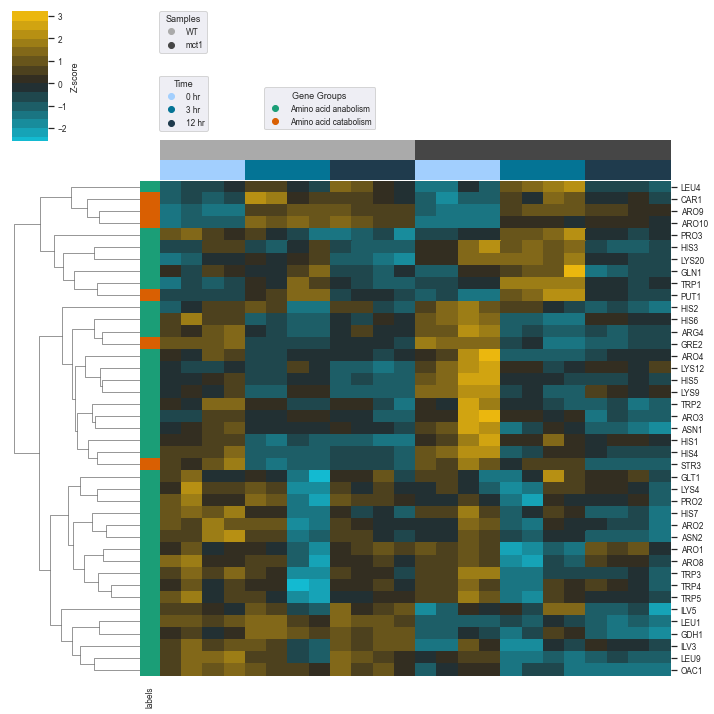

In [54]:
sns.set(font_scale=0.75)
sns.clustermap(
    rnaseq_aaSet,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    row_colors=gene_colors,
    col_colors=[col_colors1.label, col_colors2.label],
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(gene_hex.values())[i]) for i in range(len(list(gene_hex.values())))]
first_legend = plt.legend(handles, list(gene_hex.keys()), bbox_to_anchor=(7, 0.41), loc=2, borderaxespad=0., title='Gene Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(time_hex.values())[i]) for i in range(len(list(time_hex.values())))]
second_legend = plt.legend(handles, [str(x) + " hr" for x in list(time_hex.keys())], bbox_to_anchor=(4.1, 0.5), loc=2, borderaxespad=0., title='Time')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(condition_hex.values())[i]) for i in range(len(list(condition_hex.values())))]
plt.legend(handles_g, list(condition_hex.keys()), bbox_to_anchor=(4.1, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(source_url, "aa_gene_list_rnaseq.pdf"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [11]:
# AA metabolism
proteomics_aa = proteomics.reindex(aa_genes['gene_name'].tolist()).dropna(axis=0)

# nt metabolism 
proteomics_nt = proteomics.reindex(list(set(nt_genes[1].tolist()))).dropna(axis=0)

In [12]:
protein_colors = proteomics_aa.copy()
protein_colors['labels'] = protein_colors.index.map(gene_class_dict)
protein_colors = protein_colors[['labels']]
protein_colors['labels'] = protein_colors['labels'].map(gene_hex)

In [13]:
sample_hex = {
    'WT_1':'#AAAAAA', 
    'WT_2':'#AAAAAA',
    'WT_3':'#AAAAAA',
    'mct1_1':'#464646',
    'mct1_2':'#464646',
    'mct1_3':'#464646'}

proteomics_labels = proteomics_aa.T.copy()
proteomics_labels['label'] = proteomics_labels.index.map(sample_hex)
proteomics_labels = proteomics_labels[['label']]

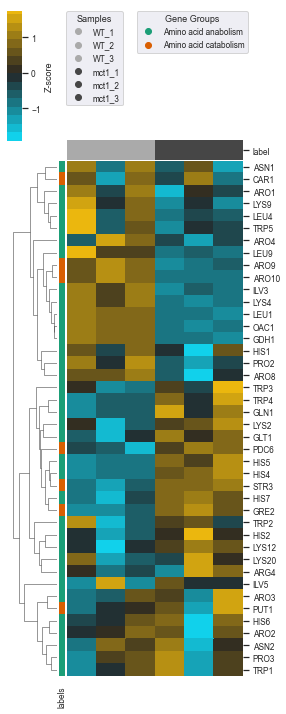

In [53]:
sns.set(font_scale=0.75)
sns.clustermap(
    proteomics_aa,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    row_colors=protein_colors,
    col_colors=proteomics_labels,
    figsize=(4,10),
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(gene_hex.values())[i]) for i in range(len(list(gene_hex.values())))]
first_legend = plt.legend(handles, list(gene_hex.keys()), bbox_to_anchor=(9, 1), loc=2, borderaxespad=0., title='Gene Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex.values())[i]) for i in range(len(list(sample_hex.values())))]
plt.legend(handles_g, list(sample_hex.keys()), bbox_to_anchor=(4.1, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(source_url, "aa_gene_list_protein.pdf"),
    dpi=600,
    bbox_inches='tight')
plt.show()

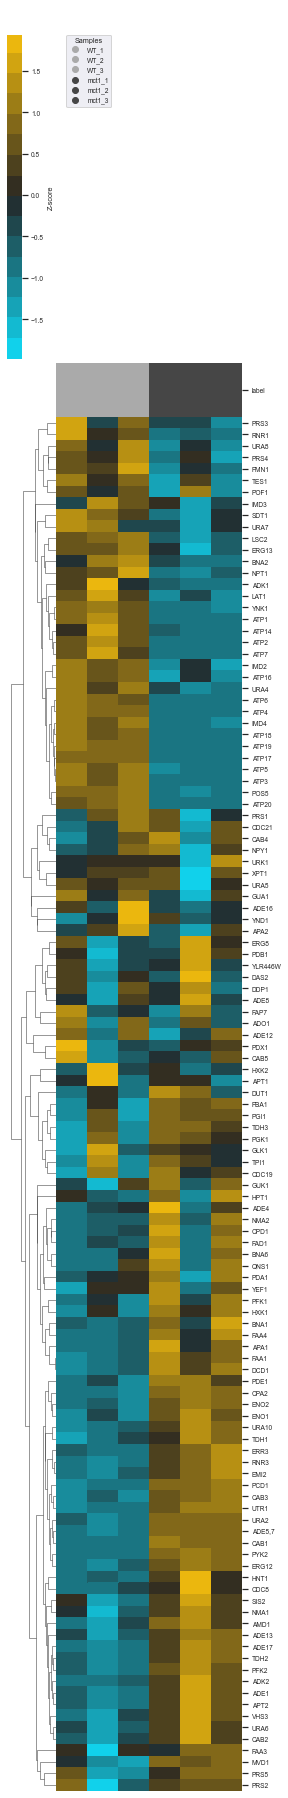

In [52]:
sns.set(font_scale=0.6)
sns.clustermap(
    proteomics_nt,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(4,25),
    cmap=jakes_cmap)

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex.values())[i]) for i in range(len(list(sample_hex.values())))]
plt.legend(handles_g, list(sample_hex.keys()), bbox_to_anchor=(4.1, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(source_url, "nt_gene_list_protein.pdf"),
    dpi=600,
    bbox_inches='tight')
plt.show()

# Metabolomics

In [16]:
mct1_url = os.path.join (source_url, "mct1_metabolomics_allValues.txt")
#ctp1_url = os.path.join (source_url, "sce_mct1_metadata.txt")

mct1_metadata_url = os.path.join (source_url, "mct1_metabolomics_metadata.txt")

metabolite_url = os.path.join (source_url, "metabolite_list.txt")

In [17]:
mct1_metabolomics = pd.read_csv(
    mct1_url,
    sep="\t",
    index_col=0)
mct1_metadata = pd.read_csv(
    mct1_metadata_url,
    sep="\t",
    index_col=0)

#ctp1_metabolomics = pd.read_csv(
#    ctp1_url,
#    sep="\t",
#    index_col=0)

metabolite_list = pd.read_csv(
    metabolite_url,
    sep="\t",
    index_col=0)

In [18]:
# Sort data by condition params
metabolomics_mct1Set = mct1_metabolomics.copy()
metabolomics_mct1Set = metabolomics_mct1Set.reindex(metabolite_list.index.tolist(), axis=0)

In [19]:
# Set labels and set color-codes for rows
metabolite_hex = {
    'amino acid':'#1b9e77', 
    'nucleotides':'#d95f02'}

metabolite_colors = metabolite_list.copy()
metabolite_colors['label'] = metabolite_colors['label'].map(metabolite_hex)

In [20]:
# Sort data by condition params
mct1_metadata = mct1_metadata.sort_values(["Condition", "Time"], ascending = (True, True))
metabolomics_mct1Set = metabolomics_mct1Set[mct1_metadata.index.tolist()]

In [21]:
# Set labels and set color-codes for cols
mct1_condition_hex = {
    'WT':'#AAAAAA', 
    'mct1':'#464646'}
mct1_time_hex = {
    '000min':'#a2cffe',
    '015min':'#047495',
    '030min':'#1f3b4d',
    '060min':'#152238',
    '180min':'#000000'}

mct1_colors = mct1_metadata.copy()

mct1_colors['Condition'] = mct1_colors['Condition'].map(mct1_condition_hex)
mct1_colors['Time'] = mct1_colors['Time'].map(mct1_time_hex)

mct1_colors1 = mct1_colors.copy()[['Condition']]
mct1_colors1.columns = ['label']
mct1_colors2 = mct1_colors.copy()[['Time']]
mct1_colors2.columns = ['label']

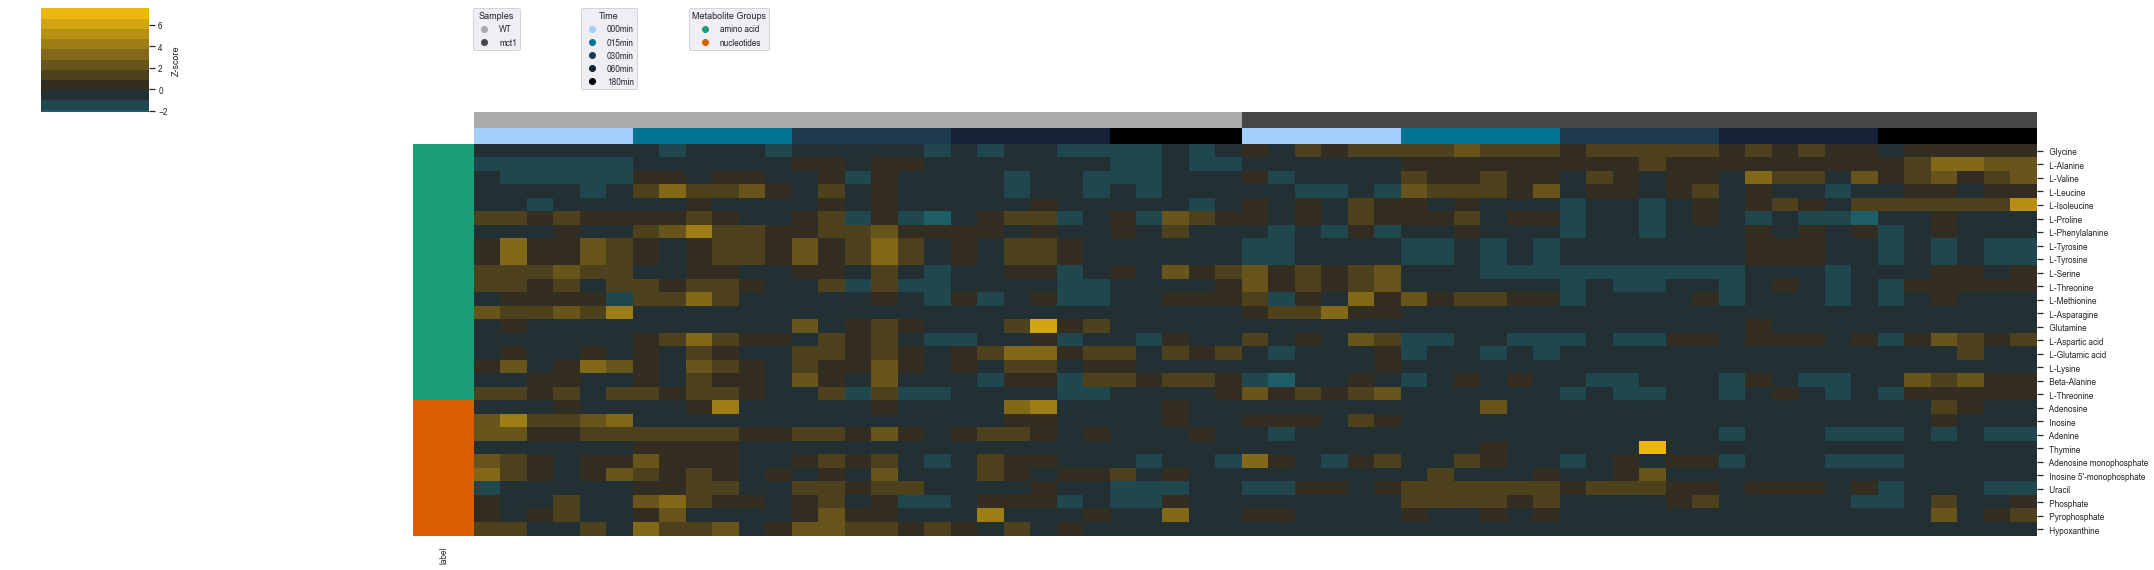

In [51]:
sns.set(font_scale=0.75)
sns.clustermap(
    metabolomics_mct1Set,
    z_score=0,
    xticklabels=False,
    row_cluster=False,
    col_cluster=False,
    center=0,
    figsize=(30,8),
    cbar_kws={'label': 'Z-score'},
    row_colors=metabolite_colors,
    col_colors=[mct1_colors1.label, mct1_colors2.label],
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(metabolite_hex.values())[i]) for i in range(len(list(metabolite_hex.values())))]
first_legend = plt.legend(handles, list(metabolite_hex.keys()), bbox_to_anchor=(6, 1), loc=2, borderaxespad=0., title='Metabolite Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(mct1_time_hex.values())[i]) for i in range(len(list(mct1_time_hex.values())))]
second_legend = plt.legend(handles, list(mct1_time_hex.keys()), bbox_to_anchor=(5, 1), loc=2, borderaxespad=0., title='Time')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(mct1_condition_hex.values())[i]) for i in range(len(list(mct1_condition_hex.values())))]
plt.legend(handles_g, list(mct1_condition_hex.keys()), bbox_to_anchor=(4, 1), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(source_url, "aa_nt_list_mct1_metabolomics.pdf"),
    dpi=600,
    bbox_inches='tight')
plt.show()

### CTP1 metabolomics

In [25]:
ctp1_url = os.path.join(source_url, "ctp1_metabolomics_allValues.txt")

ctp1_metadata_url = os.path.join(source_url, "ctp1_metabolomics_metadata.txt")

ctp1_metabolite_url = os.path.join(source_url, "ctp1_metabolite_list.txt")

In [26]:
ctp1_metabolomics = pd.read_csv(
    ctp1_url,
    sep="\t",
    index_col=0)
ctp1_metadata = pd.read_csv(
    ctp1_metadata_url,
    sep="\t",
    index_col=0)

ctp1_metabolite_list = pd.read_csv(
    ctp1_metabolite_url,
    sep="\t",
    index_col=0)

In [27]:
# Sort data by condition params
metabolomics_ctp1Set = ctp1_metabolomics.copy()
metabolomics_ctp1Set = metabolomics_ctp1Set.reindex(ctp1_metabolite_list.index.tolist(), axis=0)

In [28]:
# Set labels and set color-codes for rows
metabolite_hex = {
    'amino acid':'#1b9e77', 
    'nucleotides':'#d95f02'}

ctp1_metabolite_colors = ctp1_metabolite_list.copy()
ctp1_metabolite_colors['label'] = ctp1_metabolite_colors['label'].map(metabolite_hex)

In [29]:
# Sort data by condition params
ctp1_metadata = ctp1_metadata.sort_values(["Condition", "Media"], ascending = (False, True))
metabolomics_ctp1Set = metabolomics_ctp1Set[ctp1_metadata.index.tolist()]

In [30]:
# Only look at MCT1 cells
metabolomics_ctp1Set = metabolomics_ctp1Set[[x for x in metabolomics_ctp1Set.columns.tolist() if 'MCT' in x]]

In [31]:
# Set labels and set color-codes for cols
ctp1_condition_hex = {
    #'WT + EV':'#006666', 
    #'WT + CTP1':'#000033',
    'mct1 + EV':'#cc0033',
    'mct1 + CTP1':'#660033'}
ctp1_media_hex = {
    'SD':'#a2cffe',
    'SR':'#1f3b4d'}

ctp1_colors = ctp1_metadata.copy()
ctp1_colors = ctp1_colors.loc[[x for x in ctp1_colors.index.tolist() if 'MCT' in x]]

ctp1_colors['Condition'] = ctp1_colors['Condition'].map(ctp1_condition_hex)
ctp1_colors['Media'] = ctp1_colors['Media'].map(ctp1_media_hex)

ctp1_colors1 = ctp1_colors.copy()[['Condition']]
ctp1_colors1.columns = ['label']
ctp1_colors2 = ctp1_colors.copy()[['Media']]
ctp1_colors2.columns = ['label']

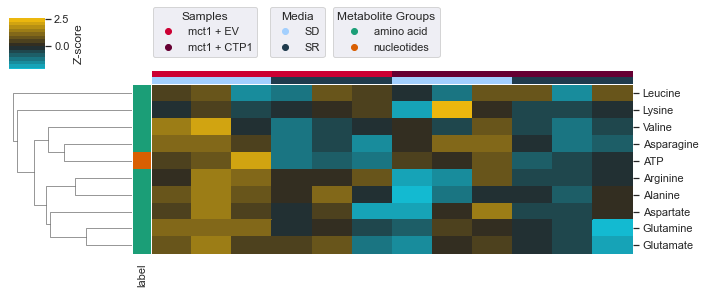

In [49]:
sns.set(font_scale=1)
sns.clustermap(
    metabolomics_ctp1Set.apply(pd.to_numeric),
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(10,4),
    cbar_kws={'label': 'Z-score'},
    row_colors=ctp1_metabolite_colors,
    col_colors=[ctp1_colors1.label, ctp1_colors2.label],
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(metabolite_hex.values())[i]) for i in range(len(list(metabolite_hex.values())))]
first_legend = plt.legend(handles, list(metabolite_hex.keys()), bbox_to_anchor=(9, 1.2), loc=2, borderaxespad=0., title='Metabolite Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(ctp1_media_hex.values())[i]) for i in range(len(list(ctp1_media_hex.values())))]
second_legend = plt.legend(handles, list(ctp1_media_hex.keys()), bbox_to_anchor=(7.25, 1.2), loc=2, borderaxespad=0., title='Media')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(ctp1_condition_hex.values())[i]) for i in range(len(list(ctp1_condition_hex.values())))]
plt.legend(handles_g, list(ctp1_condition_hex.keys()), bbox_to_anchor=(4, 1.2), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(source_url, "aa_nt_list_ctp1_metabolomics.pdf"),
    dpi=600,
    bbox_inches='tight')
plt.show()

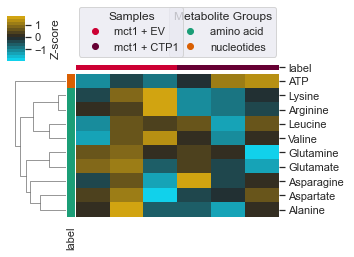

In [48]:
sns.set(font_scale=1)
sns.clustermap(
    metabolomics_ctp1Set[[
    'MCT_SR_EV1',
    'MCT_SR_EV2',
    'MCT_SR_EV3',
    'MCT_SR_A1',
    'MCT_SR_A2',
    'MCT_SR_A3']].apply(pd.to_numeric),
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(5,3.5),
    cbar_kws={'label': 'Z-score'},
    row_colors=ctp1_metabolite_colors,
    col_colors=ctp1_colors1,
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(metabolite_hex.values())[i]) for i in range(len(list(metabolite_hex.values())))]
first_legend = plt.legend(handles, list(metabolite_hex.keys()), bbox_to_anchor=(9, 1.2), loc=2, borderaxespad=0., title='Metabolite Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(ctp1_condition_hex.values())[i]) for i in range(len(list(ctp1_condition_hex.values())))]
plt.legend(handles_g, list(ctp1_condition_hex.keys()), bbox_to_anchor=(4, 1.2), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(source_url, "aa_nt_list_ctp1_metabolomics.pdf"),
    dpi=600,
    bbox_inches='tight')
plt.show()